# Entregable III.2 -  Selección de características

Francisco Javier Mercader Martínez

## Machine Learning. Grado en Ciencia de datos

Los siguientes ejercicios tienen que ser entregados antes de la finalización de la prueba, que tiene una hora de duración. Cómo realizar el entregable:


-   La realización se debe de hacer de forma  **INDIVIDUAL**
-   Se debe de enviar un notebook con el código y las explicaciones, comentarios, análisis y justificaciones en Markdown.
-   Reproducibilidad:
    -   Se debe de establecer una variable semilla con un número al inicio, esta variables será la que se utilice para el np.random_seed y para el random_state.
    -   Las bases de datos se cargan con rutas relativas.
-   El notebook se debe de subir a la tarea del aula virtual creada antes de la finalización de la hora de clase. (Ver tarea y fecha de cierre).

Dataset: Música1.csv es una dataset que describe según ciertas frecuencias si los usuarios conciben la música como relajante o no relajante. La variable objetivo es "Class". El separador es el ;

In [1]:
# Data Processing
import pandas as pd
import numpy as np
import random

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif, mutual_info_classif, chi2, f_regression, SelectFdr, SelectFpr, SelectPercentile, SelectFwe
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

%matplotlib inline

In [2]:
random_seed = 1234

np.random.seed(random_seed)

### EJERCICIO 1

1. Carga el dataset **"Musica1.csv"** , ¿cuantas características e instancias tiene?. Realiza el resto de apartados a partir de este conjunto de datos.  Analiza los datos y realiza las operaciones oportunas para que estén preparados para aplicar técnicas de selección de características.


In [3]:
df = pd.read_csv('Musica1.csv', sep=';')
df

,Class,_RMSenergy_Mean,_Lowenergy_Mean,_Fluctuation_Mean,_Tempo_Mean,_MFCC_Mean_1,_MFCC_Mean_2,_MFCC_Mean_3,_MFCC_Mean_4,_MFCC_Mean_5,...,_Chromagram_Mean_9,_Chromagram_Mean_10,_Chromagram_Mean_11,_Chromagram_Mean_12,_HarmonicChangeDetectionFunction_Mean,_HarmonicChangeDetectionFunction_Std,_HarmonicChangeDetectionFunction_Slope,_HarmonicChangeDetectionFunction_PeriodFreq,_HarmonicChangeDetectionFunction_PeriodAmp,_HarmonicChangeDetectionFunction_PeriodEntropy
0,relax,0.052,0.591,9.136,130.043,3.997,0.363,0.887,0.078,0.221,...,0.426,1.000,0.008,0.101,0.316,0.261,0.018,1.035,0.593,0.970
1,relax,0.125,0.439,6.680,142.240,4.058,0.516,0.785,0.397,0.556,...,0.002,1.000,0.000,0.984,0.285,0.211,-0.082,3.364,0.702,0.967
2,relax,0.046,0.639,10.578,188.154,2.775,0.903,0.502,0.329,0.287,...,0.184,0.746,0.016,1.000,0.413,0.299,0.134,1.682,0.692,0.963
3,relax,0.135,0.603,10.442,65.991,2.841,1.552,0.612,0.351,0.011,...,0.038,1.000,0.161,0.757,0.422,0.265,0.042,0.354,0.743,0.968
4,relax,0.066,0.591,9.769,88.890,3.217,0.228,0.814,0.096,0.434,...,0.004,0.404,1.000,0.001,0.345,0.261,0.089,0.748,0.674,0.957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,happy,0.070,0.591,6.078,142.001,1.242,0.142,0.006,0.101,0.034,...,0.732,1.000,0.269,0.625,0.368,0.184,0.076,1.682,0.823,0.969
196,happy,0.147,0.532,6.881,129.671,1.890,-0.554,0.458,0.049,0.087,...,0.058,0.358,0.375,0.182,0.386,0.205,-0.201,2.243,0.818,0.963
197,happy,0.131,0.542,7.565,168.861,2.488,-0.023,0.512,0.043,0.247,...,0.160,0.214,0.299,0.988,0.354,0.171,-0.086,1.922,0.807,0.967
198,happy,0.220,0.637,7.622,187.450,1.961,0.332,0.374,0.160,-0.021,...,0.515,1.000,0.702,0.459,0.356,0.162,-0.049,1.682,0.846,0.963


2. Implementa el algortimo de eliminación recursiva de variables utilizando como ranking de importancia de las variables los valores proporcionados por Random Forest. Aplica un hold-out 70-30. Muestra el ranking de características e indica cuales son las características seleccionadas. Explica el proceso e indica si hay mejoras en la exactitud del modelo.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Class']),
    df['Class'],
    test_size=0.3,
    random_state=random_seed
)

Primero vamos a entrenar un Random Forest básico con todas las variables para saber la importancia de las mismas y tener un "baseline" para ver si es posible mejorarlo con la eliminación de algunas variables. 

In [5]:
rf = RandomForestClassifier(random_state=random_seed)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1234)

Ahora que el modelo de Random Forest está entrenado, analizamos la exactitud del modelo en el conjunto de test

In [6]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.95


En el atributo `feature_importances_` podemos ver la importancia de cada variable calculada como la suma del decremento de la impureza cuando la variable es seleccionada para realizar la partición en un determinado nodo. 

In [7]:
rf.feature_importances_

array([0.00475808, 0.00521766, 0.00377568, 0.00217201, 0.03868642,
       0.0258135 , 0.01494394, 0.01570144, 0.00319653, 0.00325023,
       0.00519679, 0.00111328, 0.00268977, 0.00100921, 0.00406779,
       0.00254787, 0.00229249, 0.00432082, 0.01281551, 0.21165423,
       0.00596453, 0.0069714 , 0.00279484, 0.09642448, 0.03988037,
       0.08152153, 0.02130411, 0.00318909, 0.00805411, 0.0017107 ,
       0.00276053, 0.07857431, 0.00916102, 0.00929298, 0.00366221,
       0.00638992, 0.00306787, 0.00661321, 0.0010745 , 0.00404633,
       0.00069093, 0.00395288, 0.01032919, 0.00198575, 0.00674812,
       0.08249724, 0.00305066, 0.00317498, 0.1256589 , 0.00423008])

Para poder implementar nuestro proceso de eliminación recursiva de variables tenemos que crear un `Series` con `Pandas` en la que almacenar todas las variables, ordenadas de forma decreciente, la importancia de las variables y el nombre de las mismas como índice de la serie. 

In [8]:
mdi_importances = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)
mdi_importances.sort_values(ascending = False, inplace=True)

En la siguiente gráfica se muestra la importancia de las variables que se ha obtenido

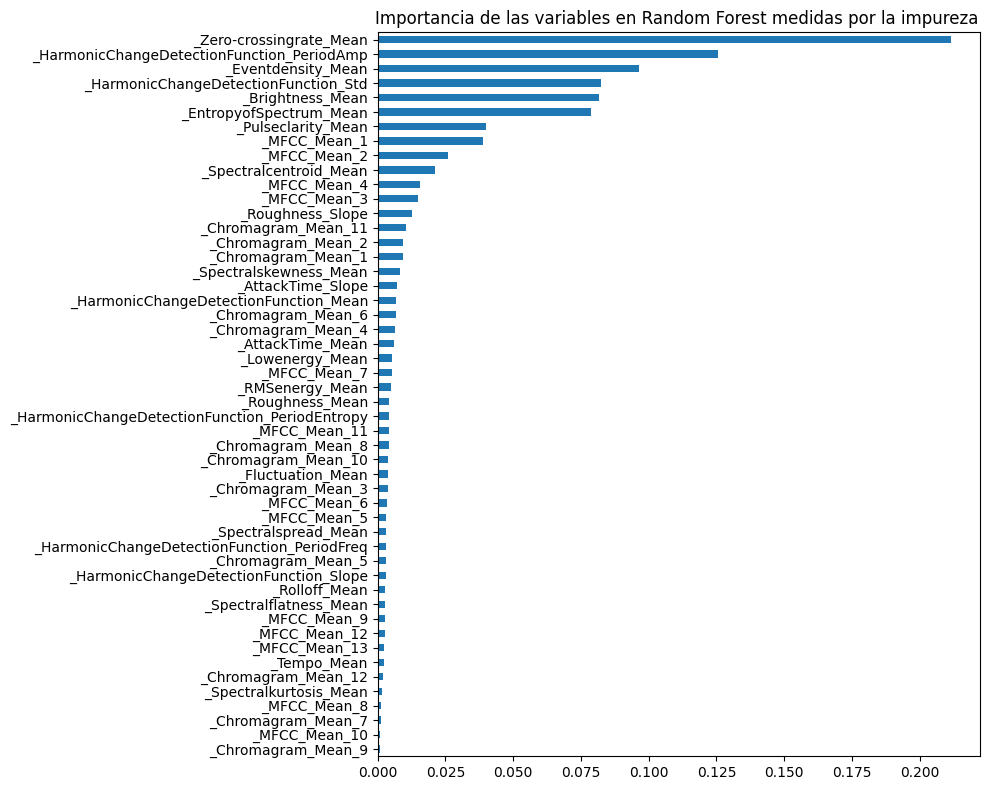

In [9]:
ax = mdi_importances.sort_values(ascending=True).plot.barh()
ax.set_title("Importancia de las variables en Random Forest medidas por la impureza ")
ax.figure.tight_layout()

3. Compara el resultado anterior con la función RFECV de sklearn ¿Coindiden los resultados? Si no, ¿por qué crees que puede ser?

In [10]:
from sklearn.pipeline import Pipeline
min_features_to_select = 3
rfecv = RFECV(RandomForestClassifier(random_state=random_seed), min_features_to_select=min_features_to_select)
rfecv.fit(X_train,y_train)

RFECV(estimator=RandomForestClassifier(random_state=1234),
      min_features_to_select=3)

In [11]:
print(f"Número óptimo de variables: {rfecv.n_features_}")
print(f"Exactitud alcanzada: {rfecv.cv_results_['mean_test_score'][rfecv.n_features_]:.3f}")

Número óptimo de variables: 7
Exactitud alcanzada: 0.964


Obtenemos una exactitud mejor en este caso, aunque la mejora no es muy significativa:

- `accuracy_rf=0.95`
- `accuracy_rfecv=0.964`

In [12]:
from operator import itemgetter
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfecv.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 _Zero-crossingrate_Mean
1 _Eventdensity_Mean
1 _Pulseclarity_Mean
1 _Brightness_Mean
1 _EntropyofSpectrum_Mean
1 _HarmonicChangeDetectionFunction_Std
1 _HarmonicChangeDetectionFunction_PeriodAmp
2 _MFCC_Mean_1
3 _MFCC_Mean_2
4 _MFCC_Mean_4
5 _Spectralcentroid_Mean
6 _Chromagram_Mean_1
7 _AttackTime_Slope
8 _Chromagram_Mean_4
9 _Chromagram_Mean_11
10 _Roughness_Slope
11 _Chromagram_Mean_2
12 _MFCC_Mean_3
13 _Rolloff_Mean
14 _HarmonicChangeDetectionFunction_PeriodEntropy
15 _Roughness_Mean
16 _Chromagram_Mean_8
17 _HarmonicChangeDetectionFunction_Mean
18 _AttackTime_Mean
19 _Chromagram_Mean_7
20 _Chromagram_Mean_6
21 _Spectralskewness_Mean
22 _Spectralkurtosis_Mean
23 _Spectralflatness_Mean
24 _Chromagram_Mean_10
25 _HarmonicChangeDetectionFunction_Slope
26 _MFCC_Mean_13
27 _Chromagram_Mean_5
28 _MFCC_Mean_9
29 _RMSenergy_Mean
30 _MFCC_Mean_6
31 _MFCC_Mean_7
32 _Tempo_Mean
33 _HarmonicChangeDetectionFunction_PeriodFreq
34 _Chromagram_Mean_12
35 _MFCC_Mean_5
36 _MFCC_Mean_12
37 _Chromag

Comparando esta lista de variables, los resultados coinciden de forma bastante parecida comparándolos con la gráfica anterior. El orden del ranking está ligeramente alterado pero las columnas coinciden.

De forma gráfica podemos analizar cómo se ha desarrollado el proceso con cada número de variables seleccionadas y analizar la desviación estándar en la validación cruzada. 

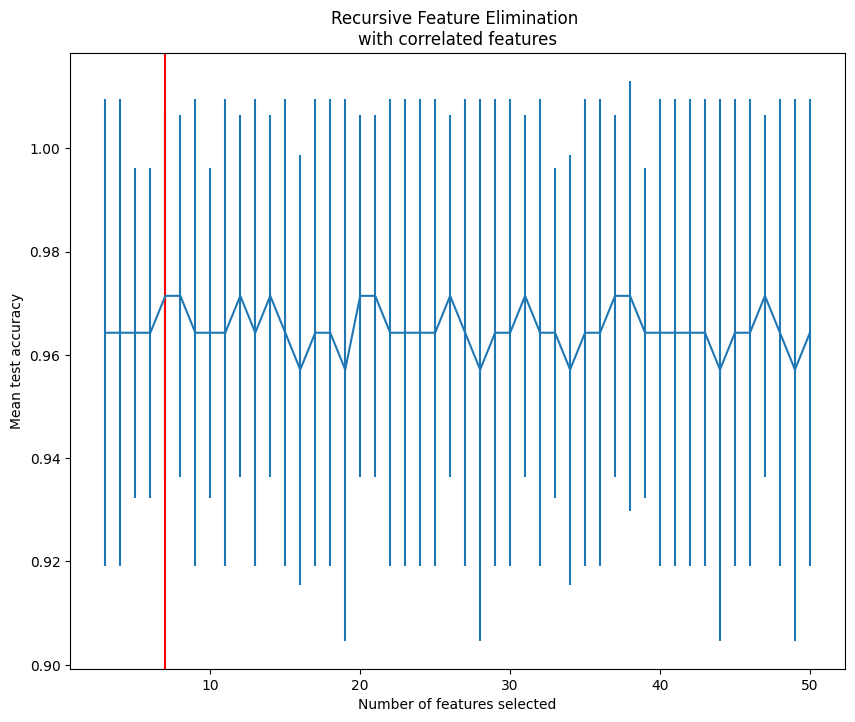

In [13]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.axvline(rfecv.n_features_, color = 'red')
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

4. Utiliza ahora la selección de características mediante filtros por la función SelectKBest utilizando la función de scoring mutual_info_classif para crear el ranking de características, quedándote con 10 características. Muestra las características seleccionadas. ¿Coinciden con las anteriores? ¿Se mejora la exactitud? Justifica los resultados.

In [14]:
k=10
Kbest = SelectKBest(f_classif, k=k).set_output(transform='pandas').fit(df.drop(columns=['Class']), df['Class'])
X_new = Kbest.fit_transform(df.drop(columns=['Class']),df['Class'])

In [15]:
# Sacamos las características extraídas usando KBest
features_kbest = [col for col in X_new.columns]

# Cogemos las primeras 10 características extraídas anteriormente
features = features[:10]

# Comparamos que todas las características coincidan con las anteriores
all(features_kbest) == all(features)

True

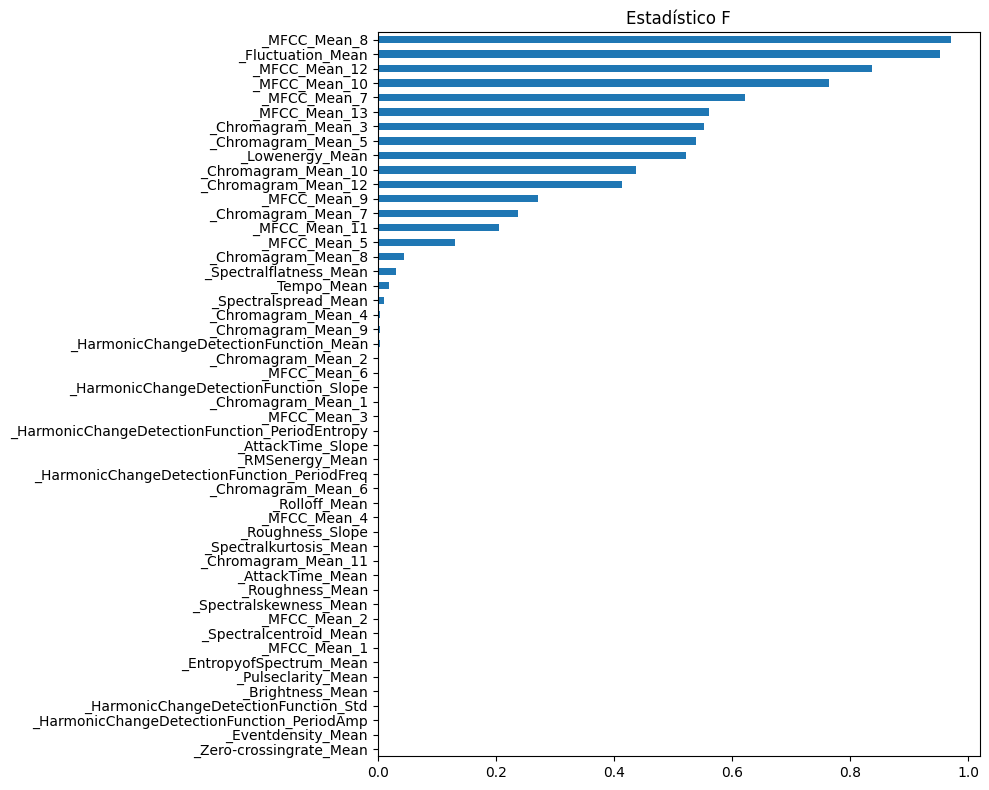

In [16]:
scores = pd.Series(Kbest.pvalues_, index=Kbest.feature_names_in_)

ax = scores.sort_values(ascending=True).plot.barh()
ax.set_title("Estadístico F")
ax.figure.tight_layout()

5. Elige una selección de caracteristicas. La del apartado 2 o la del apartado 3. Recuerda adecuar los datos a la técnica. Con dicha selección emplea un MLP para clasificar con todos las características y sólo con las características seleccionadas. Obten 2 métricas para comparar: calcula los resultados solo en el conjunto de test. ¿Qué conclusiones obtienes? ¿Las características seleccionadas son válidas para más de un modelo? 

In [17]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp = MLPClassifier()
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

mlp.fit(X_train_selected, y_train)

y_pred_selected = mlp.predict(X_test_selected)

accuracy_selected = accuracy_score(y_test, y_pred_selected)

print(f"Características inciales: \n\tAccuracy: {accuracy}")
print()
print(f"Características seleccionadas: \n\tAccuracy: {accuracy_selected}")

Características inciales: 
	Accuracy: 0.9333333333333333

Características seleccionadas: 
	Accuracy: 0.4666666666666667


c:\Users\Campus\.conda\envs\optim-2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Los resultados muestran que el modelo con todas las características iniciales tiene un rendimiento notablemente mejor que el modelo con las características seleccionadas.

Por este motivo parece que el modelo con todas las características tiene un rendimiento notablemente mejor que el modelo con las características seleccionadas.